In [1]:
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import AgentExecutor, Tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
    
from typing_extensions import TypedDict
from typing import Dict, List, Optional, Tuple, Annotated

from ollama import chat
from ollama import ChatResponse
from langchain_community.llms import Ollama


In [2]:
model = 'llama3.2' # 8B Model: "granite3-guardian:8b"


In [3]:
usecase = "Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers."

In [5]:
from langchain_ollama import ChatOllama

ollama = ChatOllama(
    model = "llama3.2",
    temperature = 0.,
    num_predict = 256,
    # other params ...
)

In [6]:
intents = ["Usecase: Chatbot for personalized healthcare", "Usecase: Chatbot for personalized healthcare", "Usecase: Chatbot for personalized healthcare", "Usecase: Time series forecasting using LLMs"]
answers = ["No", "Maybe", "Yes", "Yes"]
questions = ["Given the use-case is the following prompt relevant. Prompt: What is the date of the football World Cup? One-word answer in Yes/No/Maybe", "Given the use-case is the following prompt relevant. Prompt: Can I get a refund on my deposit since the insurance claim went through. One-word answer in Yes/No/Maybe","Given the use-case is the following prompt relevant. Prompt: Now that my tests are in the system, is it possible to get a doctor’s appointment?. One-word answer in Yes/No/Maybe", "Given the use-case is the following prompt relevant. Prompt: Given the sales dataset, what is the forecasted sales for the next quarter . One-word answer in Yes/No/Maybe"]

In [7]:
def make_prompt(use_case, queries, final_query, answers=[], intents=[]):
    if len(answers) == 0:
        cot_string = f"[Given: {use_case}] [Question: {query}]\n"
    else:
        assert len(answers) == len(intents), "Few shot intents and answers should be the same length"
        cot_string = "Few shot examples: "
        for index, cot_intent in enumerate(intents):
            cot_answer = answers[index]
            query = queries[index]
            cot_string = cot_string + f"Example: [Given: {cot_intent}] [Question: {query}] Output: [{cot_answer}]\n"
        cot_string = cot_string + f"Question: [Given: {use_case}] [Question: {final_query}]\n"
    return cot_string

def generate_few_shot(use_case, queries, final_query, answers, intents):
    cot_string = make_prompt(use_case, queries, final_query, answers, intents)
    responses = ollama.invoke(cot_string)
    return responses


In [10]:
usecase = "Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers."


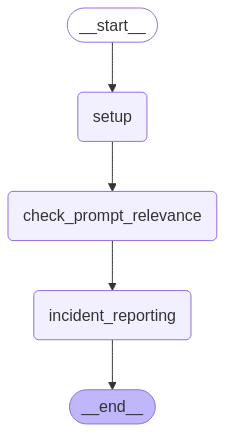

Check drift in prompts:
content='[Given: Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers.]\n\n[Question: Given the use-case is the following prompt relevant. Prompt: what is the weather today.]\n\nOutput: [Maybe]' additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2025-03-10T20:52:32.645392Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1852233917, 'load_duration': 26907792, 'prompt_eval_count': 330, 'prompt_eval_duration': 191000000, 'eval_count': 54, 'eval_duration': 1632000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-2eae5b8a-4ecb-4d2d-8b46-2653758c37bf-0' usage_metadata={'input_tokens': 330, 'output_tokens': 54, 'total_tokens': 384}
content='[Given: Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interact

In [11]:
from langchain_community.llms import Ollama
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display



# Graph state
class State(TypedDict):
    intent: str
    initial_drift_value: int
    drift_value: int
    drift_threshold: int 
    prompt: str

def message_template(user_text, risk_name):
    messages= [{
        "role": "system",
        "content": risk_name
    }, 
    {
      "role": "user",
      "content": user_text 
    },
    ]
    return messages


# Nodes
def setup(state: State):
    state['drift_value'] = 0
    return state

def check_prompt_relevance(state: State):
    for i in range(10): 
        usecase = state['intent']
        prompt = state['prompt']
        final_query = "Given the use-case is the following prompt relevant. Prompt:" + prompt + "." + "Answer in Yes/No/Maybe Output:"
        output = generate_few_shot(use_case=usecase, queries=questions, final_query=final_query, answers=answers, intents=intents)
        print(output)
        if "Yes" or "Maybe" in output:
            state['drift_value'] = state['drift_value'] + 1

    print("state", state['drift_value'])
    return {"drift_value": state['drift_value']}

def incident_reporting(state: State):
    if (state['drift_value'] > state['drift_threshold']):
        incident_report = "Alert: Potential drift in prompts identified\n"
        print(incident_report)
    else:
        incident_report = "None"
        print("No drift detected\n")
    return {"incident_report": incident_report}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("setup", setup)
workflow.add_node("check_prompt_relevance", check_prompt_relevance)
workflow.add_node("incident_reporting", incident_reporting)

# Add edges to connect nodes
workflow.add_edge(START, "setup")

workflow.add_edge("setup", "check_prompt_relevance")
workflow.add_edge("check_prompt_relevance", "incident_reporting")

workflow.add_edge("incident_reporting", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
print("Check drift in prompts:")
prompt1 = "what is the weather today"
state = chain.invoke({"drift_threshold":2, 'intent': usecase, 'prompt': prompt1})
print("\n--- --- ---\n")





